**Last Update**: Oct 2020 <br />
**Jupyter Notebook**: [Tutorial2_Classical_Machine_Learning_Boucheron.ipynb](https://geospatial.101workbook.org/tutorials/Tutorial2_Classical_Machine_Learning_Boucheron.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ISUgenomics/geospatialworkbook/HEAD?filepath=tutorials)

# Tutorial 2: Classical Machine Learning Fundamentals

## Laura E. Boucheron, Electrical & Computer Engineering, NMSU

### October 2020

Copyright (C) 2020  Laura E. Boucheron

This information is free; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 3 of the License, or (at your option) any later version.

This work is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this work in a file `COPYING.TXT`; if not, If not, see <https://www.gnu.org/licenses/>.

## Overview
In this tutorial, we present a brief overview of classical machine learning concepts as applicable to image classification applications.  Completion of this tutorial should give participants the basic background and terminology necessary for an understanding of the basics of classical machine learning as applied to image classification.  In this tutorial, we will develop a classical machine learning algorithm capable of discriminating between objects present in an image.

This tutorial contains 5 sections:
  - **Section 0: Preliminaries**: some notes on using this notebook, how to download the image dataset that we will use for this tutorial, and import commands for the libraries necessary for this tutorial
  - **Section 1: Working with the CalTech101 Dataest**: how to traverse and use the directory structure and files provided in the CalTech101 Dataset
  - **Section 2: Feature Extraction**: examples of extraction of different feature categories from images, including color, region, and texture features
    - **Section 2.1: Color Features**: statistics of the color within an image object
    - **Section 2.2: Region Features**: measures of the size and shape of the image object
    - **Section 2.3: Texture Features**: measures of the distribution of intensities within the image object
  - **Section 3: Setting up a Feature Matrix and Label Vector**: aggregating features into a feature matrix in the format expected by machine learning algorithms along with definition of a label vector
  - **Section 4: Classification**: examples of common classification methods, including training and testing on the CalTech101 dataset
  
There are subsections with the heading "**<span style='color:Green'> Your turn: </span>**" throughout this tutorial in which you will be asked to apply what you have learned.

# Section 0: Preliminaries 
## Section 0.1: A Note on Jupyter Notebooks

There are two main types of cells in this notebook: code and markdown (text).  You can add a new cell with the plus sign in the menu bar above and you can change the type of cell with the dropdown menu in the menu bar above.  As you complete this tutorial, you may wish to add additional code cells to try out your own code and markdown cells to add your own comments or notes. 

Markdown cells can be augmented with a number of text formatting features, including
  - bulleted
  - lists

embedded $\LaTeX$, monotype specification of `code syntax`, **bold font**, and *italic font*.  There are many other features of markdown cells--see the jupyter documentation for more information.

You can edit a cell by double clicking on it.  If you double click on this cell, you can see how to implement the various formatting referenced above.  Code cells can be run and markdown cells can be formatted using Shift+Enter or by selecting the Run button in the toolbar above.

Once you have completed (all or part) of this notebook, you can share your results with colleagues by sending them the `.ipynb` file.  Your colleagues can then open the file and will see your markdown and code cells as well as any results that were printed or displayed at the time you saved the notebook.  If you prefer to send a notebook without results displayed (like this notebook appeared when you downloaded it), you can select ("Restart & Clear Output") from the Kernel menu above.  You can also export this notebook in a non-executable form, e.g., `.pdf` through the File, Save As menu.

## Section 0.2 Downloading Images
In this tutorial, we will use the CalTech101 dataset, which is a standard dataset used for image classification.  You can find important information about this dataset at (http://www.vision.caltech.edu/Image_Datasets/Caltech101/).  From that webpage, download the dataset itself (http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) (126 MB) and also the annotations (http://www.vision.caltech.edu/Image_Datasets/Caltech101/Annotations.tar) (13 MB) which will allow us to focus our feature extraction on only the objects in the images.  

Extract the image dataset and the annotations in your working directory.  The images will extract to a `101_ObjectCategories/` directory, under which there are 102 directories named according to the object contained in the image (e.g., `accordion/` or `pizza/`), under which are files with file format `image_XXXX.jpg`, where `XXXX` is a four digit number.  The annotations will extract to an `Annotations/` directory, underneath which there are 101 directories named the same categories (for the most part) as the `101_ObjectCategories/` categories, under which  are files `annotation_XXXX.mat`, where `XXXX` is a four digit number.  There are also 5 other files in the `Annotations/` directory.  In order to make subsequent code run more easily:
  - Within `101_ObjectCategories/`:
        ◦ Delete directory `BACKGROUND_Google/`
  - Within `Annotations/`:
        ◦ Delete `*.mat`
        ◦ Delete `README*`
        ◦ Move (rename) directory `Airplanes_Side_2/` to `airplanes/`
        ◦ Move (rename) directory `Faces_2/` to `Faces/`
        ◦ Move (rename) directory `Faces_3/` to `Faces_easy/`
        ◦ Move (rename) directory `Motorbikes_16/` to `Motorbikes/`

## Section 0.3a Import Necessary Libraries (For users using a local machine)
Here, at the top of the code, we import all the libraries necessary for this tutorial.  We will introduce the functionality of any new libraries throughout the tutorial, but include all import statements here as standard coding practice.  We include a brief comment after each library here to indicate its main purpose within this tutorial.

It would be best to run this next cell before the workshop starts to make sure you have all the necessary packages installed on your machine.

In [1]:
import matplotlib.pyplot as plt # visualization
import numpy as np # mathematical and scientific functions
import os # interaction with OS for file manipulation
import glob # a nice unix-style interface for path and file manipulation
import imageio # image I/O
import skimage.measure # measure region properties
import skimage.feature # measure region properties
import scipy.io as spio # ability to load Matlab .mat files
import sklearn # common classifiers
import sklearn.metrics # classification metrics
from sklearn import svm # the support vector machine classifier

# format matplotlib options
%matplotlib inline
plt.rcParams.update({'font.size': 20})

## Section 0.3b Build the Conda Environment (For users using the ARS HPC Ceres with JupyterLab)
Open a terminal from inside JupyterLab (File > New > Terminal) and type the following commands
```
source activate
conda create --name NMSU-AI-Workshop_image-processing python=3.7 numpy matplotlib imageio scikit-image ipykernel -y
```
It may take 5 minutes to build the Conda environment. 

When the environment finishes building, select this environment as your kernel in your Jupyter Notebook (click top right corner where you see Python 3, select your new kernel from the dropdown menu, click select) 

You will want to do this BEFORE the workshop starts.

# Section 1: Working with the CalTech101 Dataset
## Section 1.1: Exploring the Images
In the previous tutorial, we were working with only two images.  There are more than 8000 images in 101 different directories in the CalTech101 dataset.  We thus need to develop ways to efficiently loop over larger image datasets and access the images without hard coding the image filenames.  

Here, we will use the `glob` library to store directory names and filenames in a list.  You can store the directory names of the CalTech101 dataset in a list with `categories=sorted(glob.glob('101_ObjectCategories/*')`.  This list now gives you a means to loop over the 101 different categories of objects in that `categories[k]` is the `k`-th category name as a string (including the string `101_ObjectCategories/` prepended to the category name).  A few other notes:
  - `glob.glob` returns an unordered list.  We wrap a `sorted` around the `glob.glob` command to return the directories or filenames in the usual alphabetical order
  - `glob.glob` returns a list with the full pathname (from where you searched) prepended.  In this case, since we search from the directory just under `101_ObjectCategories/`, the string `101_ObjectCategories/` will be prepended to each of the 101 object categories.  If we had searched using a more complete path, e.g., `categories=sorted(glob.glob('/home/user/tutorials/101_ObjectCategories/*')`, the full specified path would be prepended to each of the categories.  The full pathname is very helpful if you need to access something within that path since you don't need to manually preprend the full path.
  - `os.path.basename` will strip off only the base directory or filename from the full path if you don't want the full path.

Using this list `categories`, we can read in the first image (`image_0001.jpg`) from each of the 101 categories and display that image in one location of an $11\times10$ subplot.  We can also title each of those locations of the subplot with the category name.  We note that this code is not robust in the sense that we are relying on the existence of a specific filename format under each of the directories in `101_ObjectCategories`.  We will work with more robust means to traverse the files that exist in each directory in later portions of this tutorial.

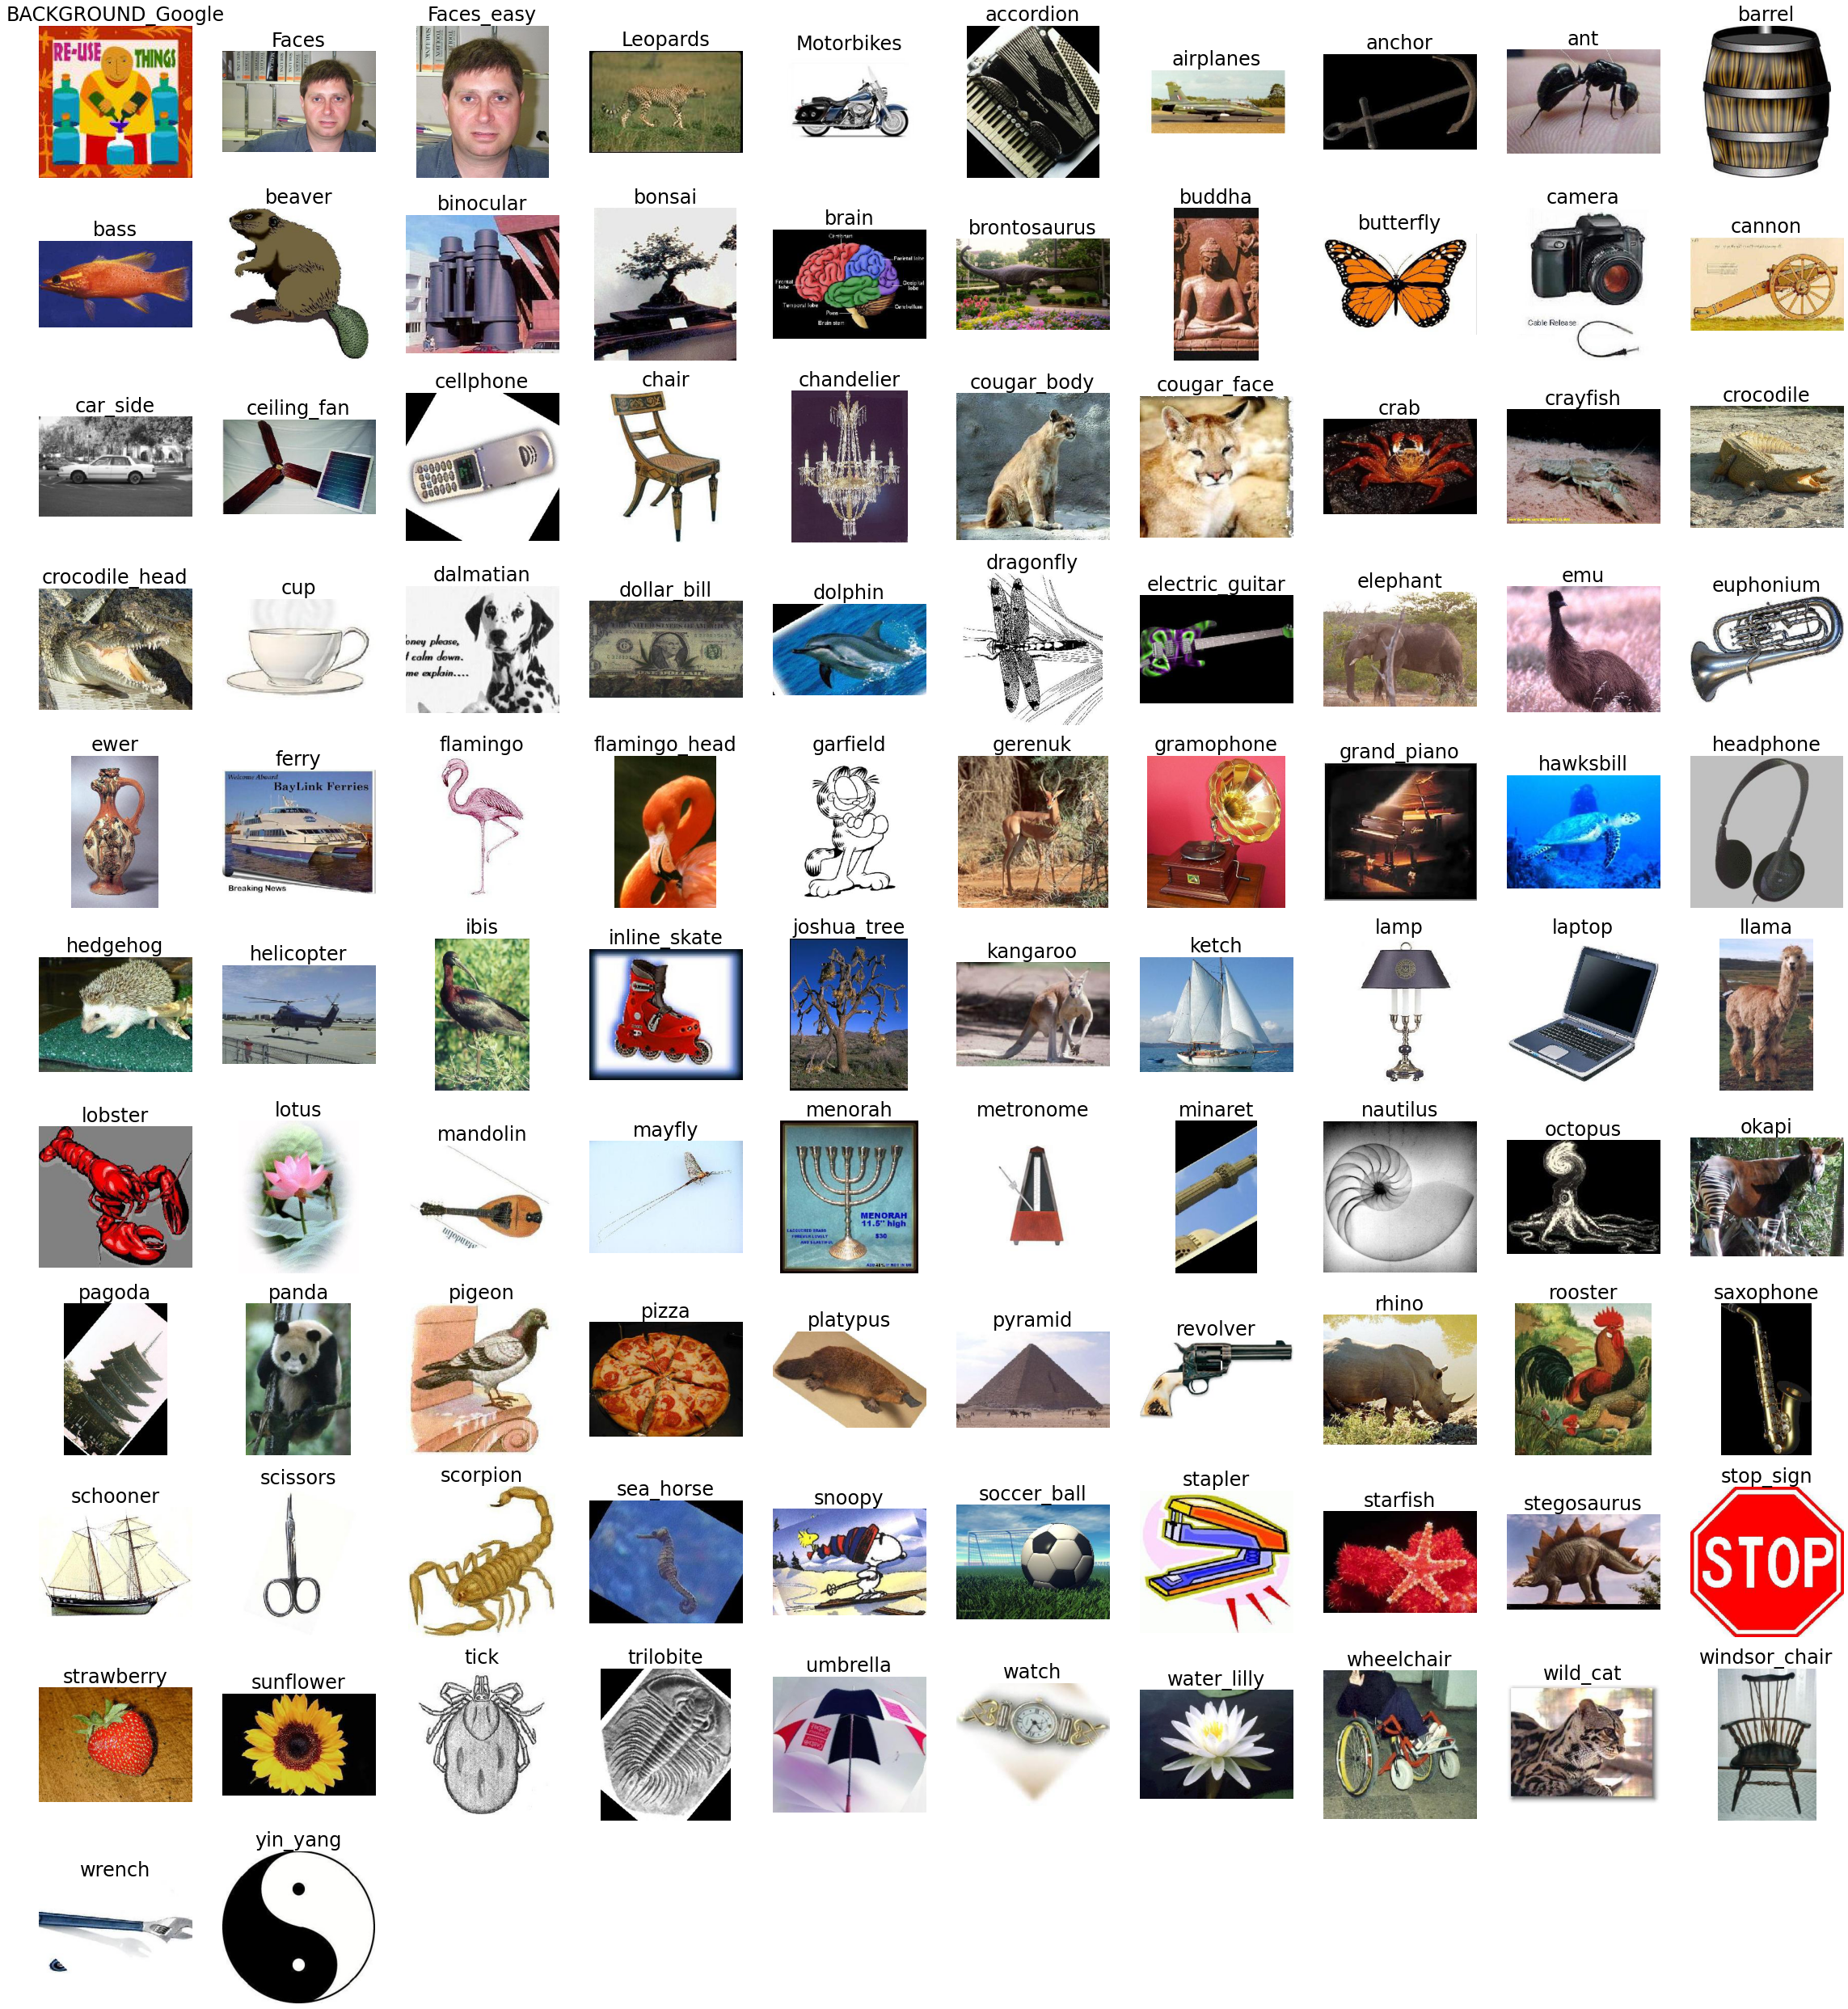

In [2]:
categories=sorted(glob.glob('101_ObjectCategories/*'))

plt.figure(figsize=(40,45))
for k, category in enumerate(categories):
    I = np.asarray(imageio.imread(category+'/image_0001.jpg'))  # category has full path
    if len(I.shape)==2:
        plt.set_cmap('gray') # change colormap to be gray
    plt.subplot(11,10,k+1) # access the k-th supblot in an 11x10 grid
    plt.imshow(I) 
    plt.axis('off')
    plt.title(os.path.basename(category)) # strip off basename for title

## Section 1.2 Exploring the Annotations
### Section 1.2.1 Plotting the annotations as a boundary over the image
The annotations are stored in Matlab's `.mat` format, which the `scipy.io` library in python can load.  Above, we have imported `scipy.io` as `spio`.  The image annotations can be read in with the `spio.loadmat` function, e.g., `ann=spio.loadmat('filename.mat')`.  The `spio.loadmat` function returns a dictionary with variable names as keys.  In the CalTech101 annotations, dictionary entry `ann['box_coord']` is a $1\times4$ vector of bounding box coordinates and `ann['obj_contour']` is a $2\times K$ vector of pixel locations which outline the contour of the object, where $K$ will be different for different annotations.  

As an example, we read in `Annotations/emu/annotation_0001.mat` and display `box_coord` and `obj_contour`.  The object contour points `obj_contour` are (for reasons unbeknownst to us) offset by the upper left `box_coord` coordinates.  

As a further example, we read in the corresponding image `101_ObjectCategories/emu/image_0001.jpg` and display it.  On top of that image, we plot the annotation outline with a basic plot command `plt.plot(ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,'w')`.  A few notes:
  - We offset the contour points by the upper left corner of the bounding box.
  - We need to offset all the points by -1 due to the difference in indexing in Matlab (starting at 1) and python (starting at 0).  Since the annotations were output in Matlab, the indexing is consistent with Matlab convention.
  - We note that the annotations appear to be provided in standard Euclidean coordinates, i.e., assuming an x-axis (column), y-axis (row) ordering.
  - We note that since we first displayed the image using `plt.imshow`, the axes for the figure are assumed to have the origin in the top left.  The `plt.plot` command will use the plotting coordinate conventions of x-axis, y-axis, but will follow the origin set up by the image visualization.
  - All of the aforementioned observations were noted based on exploration of visualization of the annotations and hard-learned lessons regarding conventions in coordinate systems for images and image metadata.  Some insights were additionally gathered from the `show_annotation.m` file from http://www.vision.caltech.edu/Image_Datasets/Caltech101/show_annotation.m (the link appears to be currently broken, however).

box_coord
[[  7 247  72 293]]
obj_contour
[[ 16.57982456  14.46578947  11.50614035   9.39210526  18.27105263
   29.26403509  36.8745614   39.83421053  47.86754386  36.45175439
   31.37807018  43.21666667  77.46403509 104.52368421 127.77807018
  159.06578947 189.93070175 204.30614035 215.29912281 213.60789474
  163.29385965 141.30789474 123.12719298  92.68508772  74.92719298
   50.82719298  19.11666667   6.85526316   6.00964912  17.4254386
   17.4254386 ]
 [ 78.93070175  53.98508772  28.19385965  10.43596491   2.8254386
    5.3622807   13.81842105  25.23421053  34.95877193  35.38157895
   42.99210526  81.04473684 119.94298246 117.82894737 123.3254386
  141.08333333 168.98859649 196.47105263 229.87280702 240.02017544
  240.44298246 217.18859649 240.44298246 240.02017544 232.83245614
  223.10789474 193.51140351 163.49210526 113.60087719  78.50789474
   78.50789474]]


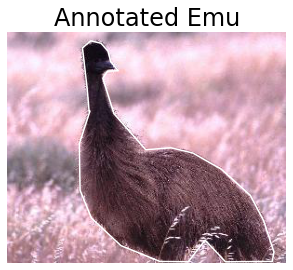

In [3]:
I = np.asarray(imageio.imread('101_ObjectCategories/emu/image_0001.jpg'))

plt.figure(figsize=(5,5))
plt.imshow(I)

ann = spio.loadmat('Annotations/emu/annotation_0001.mat')
print('box_coord')
print(ann['box_coord'])
print('obj_contour')
print(ann['obj_contour'])

# ann['box_coord'] appears to have the bounding box vertices specified as 
# [row_min, row_max, col_min, col_max] or [y_min, y_max, x_min, x_max]
# ann['obj_contour'] appears to have the column indices (x-axis) in the zeroth row and the 
# row indices (y-axis) in the first row

# plot expects the x-axis first and the y-axis second (col first, row second)
plt.plot(ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
         ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,'w')
plt.axis('off')
plt.title('Annotated Emu')
plt.show()

### Section 1.2.2 Some common coordinate issues that may be encountered with annotations
We noted above that since we first displayed the image using `plt.imshow`, the axes for the figure are assumed to have the origin in the top left.  The `plt.plot` command will use the plotting coordinate conventions of x-axis, y-axis, but will follow the origin set up by the image visualization.  We further explore this issue by using the same plotting command `plt.plot(ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,'r')` as above, but without first visualizing the image.  This means that the `plt.plot` command is expected to use the plotting coordinate conventions of x-axis, y-axis and have the origin in the bottom left.

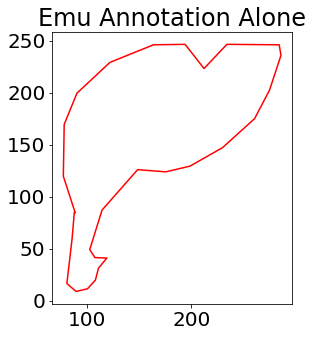

In [4]:
plt.figure(figsize=(5,5))
plt.plot(ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
         ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,'r')
plt.title('Emu Annotation Alone')
plt.axis('image') # this just makes the aspect ratio consistent rather than "stretching" the image
plt.show()

#### Reversing coordinates 
A very common mistake in plotting (x,y) coordinates on top of images is accidentally reversing the order of the coordinates.  Given the rotated coordinate system used for images, this can cause a common "rotation" of expected results.  If we accidentally plotted the annotation in row, column order, we would achieve something like follows.

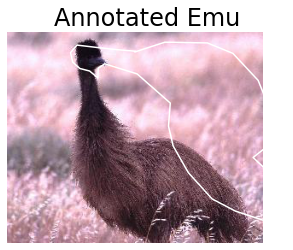

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(I)
plt.plot(ann['obj_contour'][1,:]+ann['box_coord'][0,2]-1,\
         ann['obj_contour'][0,:]+ann['box_coord'][0,0]-1,'w')
plt.axis('off')
plt.title('Annotated Emu')
plt.show()

### Section 1.2.3 Computing a binary object mask from the annotation data
You can use the object contour outline to define a binary image image mask with `r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,(M,N)); A=np.zeros(M,N); A[r,c]=1;` (note that the object contour indices are swapped here versus the plot command used above due to the difference in coordinate systems of image versus plot) where `M`, `N` are the dimensions of the image. 

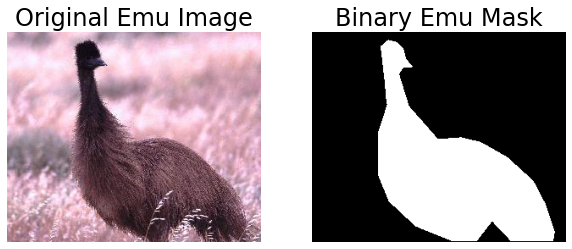

In [6]:
r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
         ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,I.shape)
A = np.zeros(I.shape)
A[r,c] = 1

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off')
plt.title('Original Emu Image')
plt.subplot(1,2,2)
plt.imshow(A,cmap='gray')
plt.axis('off')
plt.title('Binary Emu Mask')
plt.show()

## <span style='color:Green'> Your turn: </span>
Using what you have learned about using lists to loop over categories, load the first annotation (`annotation_0001.mat`) from each of the 101 categories, use the corresponding `obj_contour` to define an object mask, and display that mask in one location of an $11\times10$  subplot.  Title each of those locations of the subplot with the category name.  You might find it handy to read in the image corresponding to the annotation in order to easily get the dimensions.  The visualizations from the previous part can be used here to spot-check the correctness of the annotations.

NotADirectoryError: [Errno 20] Not a directory: 'Annotations/FeatureDetectionQuality.mat/annotation_0001.mat'

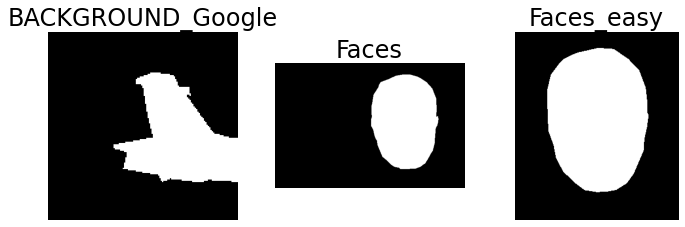

In [7]:
# ann['box_coord'] appears to have the bounding box vertices specified 
# as [row_min, col_min, row_max, col_max] or [y_min, x_min, y_max, 
# x_max]
# ann['obj_contour'] appears to have the row indices (y-axis) in the 
# zeroth row and the column indices (x-axis) in the first row

im_categories = sorted(glob.glob('101_ObjectCategories/*'))
an_categories = sorted(glob.glob('Annotations/*'))

plt.figure(figsize=(40,45))
for k, im_category in enumerate(im_categories):
    an_category = an_categories[k] # category has full path
    ann = spio.loadmat(an_category+'/annotation_0001.mat')
    I = imageio.imread(im_category+'/image_0001.jpg')
    r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+\
                               ann['box_coord'][0,0]-1,\
                               ann['obj_contour'][0,:]+\
                               ann['box_coord'][0,2]-1,I.shape)
    A = np.zeros(I.shape)
    A[r,c] = 1
    plt.subplot(11,10,k+1) # access the k-th supblot in an 11x10 grid
    plt.imshow(A,cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(im_category)) # strip off basename for title

## Section 2: Feature Extraction
In this section we will define several functions designed to extract different categories of features from images.  These functions will span several common categories of features, but are by no means a comprehensive list.  These feature extraction methods are illustration of so-called "hand-designed" features.  These are features that are specifically implemented as features that are expected to be helpful for discriminating between different image categories.

### Section 2.1 Color Features
In this section, we will extract a set of features designed to charaterize the colors present in an image.  We use the annotation mask as defined above to focus our attention on features only within the object of interest rather than features of the entire image.

### Section 2.1.1 Defining color statistics 
Here we create a function `f,fnames=extract_color_features_rgb(im,mask)` with inputs `im`, the image from which to extract features, and the binary annotation mask, `mask`.  Outputs will be a length-15 feature vector `f` describing statistics of the colors within the image object and a length-15 list `fnames` with the feature names.  We extract statistics from the red, green, and blue channels of the image.  From each channel, we compute the mean, standard deviation, median, min, and max value of pixels *within the object mask*.  We order the features by channel first in the order given above and by statistic second in the order given above (i.e., the first and second features will be mean and standard deviation of the red channel).  We assign brief, descriptive strings for each feature and store those in `fnames` (e.g., `'R_mean'`, and `'R_std'` as names for the first two features).  Note that we also need to take care of the situation in which the image is a grayscale image, i.e., only one channel by using the `skimage.color.gray2rgb` function to convert to an RGB image.

In [8]:
def extract_color_features_rgb(im,mask):
    if len(im.shape)==2:
        im = skimage.color.gray2rgb(im)
    R = im[:,:,0]
    G = im[:,:,1]
    B = im[:,:,2]
    
    f = np.array([])
    f = np.append(f,[R[mask>0].mean(), R[mask>0].std(), np.median(R[mask>0]), \
                     R[mask>0].min(), R[mask>0].max()])
    f = np.append(f,[G[mask>0].mean(), G[mask>0].std(), np.median(G[mask>0]), \
                     G[mask>0].min(),  G[mask>0].max()])
    f = np.append(f,[B[mask>0].mean(), B[mask>0].std(), np.median(B[mask>0]), \
                     B[mask>0].min(),  B[mask>0].max()])

    fnames = ('R_mean','R_std','R_median','R_min','R_max',\
              'G_mean','G_std','G_median','G_min','G_max',\
              'B_mean','B_std','B_median','B_min','B_max')
    return f, fnames

### Section 2.1.2 Extracting color statistics
Using `101_ObjectCategories/emu/image_0001.jpg` as the input image `im` and `Annotations/emu/annotation_0001.mat` as the annotation mask `mask`, we use the `extract_color_features_rgb` function and print out the `f` vector and the `fnames` list.  These features may not mean much to us as printed, but such a printed output can be used as a sanity check.

In [9]:
im = np.asarray(imageio.imread('101_ObjectCategories/emu/image_0001.jpg'))
ann = spio.loadmat('Annotations/emu/annotation_0001.mat')
r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                           ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                           (im.shape[0],im.shape[1]))
mask = np.zeros((im.shape[0],im.shape[1]))
mask[r,c] = 1
    
f,fnames = extract_color_features_rgb(im,mask)

print('feature vector')
print(f)
print('feature names')
print(fnames)

feature vector
[ 89.66263904  41.77544731  85.           3.         255.
  60.43520174  36.47920188  53.           0.         250.
  70.16239913  37.50792712  63.           0.         255.        ]
feature names
('R_mean', 'R_std', 'R_median', 'R_min', 'R_max', 'G_mean', 'G_std', 'G_median', 'G_min', 'G_max', 'B_mean', 'B_std', 'B_median', 'B_min', 'B_max')


## <span style='color:Green'> Your turn: </span>
Create a feature extraction function `f,fnames=extract_color_features_hsv(im,mask)` with inputs `im`, the image from which to extract features, and the binary annotation mask, `mask`.  Outputs will be a length-15 feature vector `f` describing statistics of the colors in HSV space within the image object and a length-15 list `fnames` with the feature names.  Extract statistics from the hue, saturation, and value channels of the image.  From each channel, compute the mean, standard deviation, median, min, and max value of pixels within the object mask.  In order to convert between the RGB and HSV color space, use the command `skimage.color.rgb2hsv`.  Order the features by channel first in the order given above and by statistic second in the order given above (i.e., the first and second features will be mean and standard deviation of the hue channel).  Assign brief, descriptive strings for each feature and store those in `fnames` (e.g., `'H_mean'`, and `'H_std'` as names for the first two features).  

In [10]:
def extract_color_features_hsv(im,mask):
    if len(im.shape)==2:
        im = skimage.color.gray2rgb(im)
    HSV = skimage.color.rgb2hsv(im)
    H = HSV[:,:,0]
    S = HSV[:,:,1]
    V = HSV[:,:,2]
    
    f = np.array([])
    f = np.append(f,[H[mask>0].mean(), H[mask>0].std(), np.median(H[mask>0]), \
                     H[mask>0].min(),  H[mask>0].max()])
    f = np.append(f,[S[mask>0].mean(), S[mask>0].std(), np.median(S[mask>0]), \
                     S[mask>0].min(),  S[mask>0].max()])
    f = np.append(f,[V[mask>0].mean(), V[mask>0].std(), np.median(V[mask>0]), \
                     V[mask>0].min(),  V[mask>0].max()])

    fnames = ('H_mean','H_std','H_median','H_min','H_max',\
              'S_mean','S_std','S_median','S_min','S_max',\
              'V_mean','V_std','V_median','V_min','V_max')
    return f, fnames

In [11]:
im = np.asarray(imageio.imread('101_ObjectCategories/emu/image_0001.jpg'))
ann = spio.loadmat('Annotations/emu/annotation_0001.mat')
r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                           ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                           (im.shape[0],im.shape[1]))
mask = np.zeros((im.shape[0],im.shape[1]))
mask[r,c] = 1
    
f,fnames = extract_color_features_hsv(im,mask)

print('feature vector')
print(f)
print('feature names')
print(fnames)

feature vector
[0.93191605 0.07237925 0.94736842 0.         0.99666667 0.36125379
 0.11130164 0.34951456 0.01960784 1.         0.35243261 0.16304442
 0.33333333 0.01960784 1.        ]
feature names
('H_mean', 'H_std', 'H_median', 'H_min', 'H_max', 'S_mean', 'S_std', 'S_median', 'S_min', 'S_max', 'V_mean', 'V_std', 'V_median', 'V_min', 'V_max')


### Section 2.2 Region features
In this section, we will extract a set of features designed to characterize the size and shape of an image object.  We use the annotation mask as defined above to define the object of interest.

### Section 2.2.1: Defining region features
We will use the `skimage.measure.regionprops` function to compute a list of region-based features in the `extract_region_features` function below.  We will not use all of the features available in `skimage.measure.regionprops` because some of those features may not be useul in our image classification situation.  For example, the centroid of the object or the orientation of the object may bias the classifier to translation or rotation variance.  In all subsequent discussion, the term "region" is used to denote the annotated region in an image.  The 19 features extracted below are measures of region characteristics of a region, including:
 - `'area'`: the number of pixels in the region
 - `'bbox_area'`: the number of pixels in the bounding box that contains the region
 - `'convex_area'`: the number of pixels in the convex hull of the region (think about "snapping a rubber band" around the region--that is the convex hull)
 - `'eccentricity'`: eccentricity of the ellipse with the same second order moments as the region
 - `'equivalent_diameter'`: the diameter of the circle with the same area as the region
 - `'euler_number'`: a measure of the "holy-ness" of the region
 - `'extent'`: ratio of area of the region to area of the bounding box
 - `'filled_area'`: the number of pixels in the region if the holes were filled
 - `'major_axis_length'`: the length of the major axis of the ellipse with the same second order moments as the region
 - `'minor_axis_length'`: the length of the minor axis of the ellipse with the same second order moments as the region
 - `'moments_hu'`: seven weighted moments (averages) of the region, designed to be invariant to rotation, scale, and translation of the region
 - `'perimeter'`: the length of the perimeter of the object (measured in number of pixels)
 - `'solidity'`: ratio of area of the region to convex area of the region

In [12]:
def extract_region_features_try1(mask):
    props = skimage.measure.regionprops(mask.astype(int))

    f = np.array([props[0].area, props[0].bbox_area, props[0].convex_area,\
                  props[0].eccentricity, props[0].equivalent_diameter,\
                  props[0].euler_number, props[0].extent, props[0].filled_area,\
                  props[0].major_axis_length, props[0].minor_axis_length,\
                  props[0].moments_hu, props[0].perimeter, props[0].solidity])

    fnames = ('area', 'bbox_area', 'convex_area', 'eccentricity',\
              'equivalent_diameter', 'euler_number', 'extent', 'filled_area',\
              'major_axis_length', 'minor_axis_length', 'moments_hu',\
              'perimeter', 'solidity')
        
    return f,fnames

### Section 2.2.2: Extracting region features
Using `101_ObjectCategories/emu/image_0001.jpg` as the input image `im` and `Annotations/emu/annotation_0001.mat` as the annotation mask `mask`, we use the `extract_region_features_try1` function and print out the `f` vector and the `fnames` list. Depending on your version of python, you may get a deprecation warning when running the following code.  That deprecation warning is related to the issue that you will explore in the next **<span style='color:Green'> Your turn: </span>** block.

In [13]:
im = np.asarray(imageio.imread('101_ObjectCategories/emu/image_0001.jpg'))
ann = spio.loadmat('Annotations/emu/annotation_0001.mat')
r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                           ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                           (im.shape[0],im.shape[1]))
mask = np.zeros((im.shape[0],im.shape[1]))
mask[r,c] = 1
    
f,fnames = extract_region_features_try1(mask.astype(int))

print('feature vector')
print(f)
print('feature names')
print(fnames)

feature vector
[22925 49742 28789 0.86209198262317 170.8479340321492 1
 0.46087813115676896 22925 270.70752758375147 137.18153400649817
 array([2.51094162e-01, 2.20473857e-02, 6.43740783e-03, 1.26777654e-03,
       2.54548085e-06, 1.25658455e-05, 2.57636709e-06])
 824.5655839020935 0.7963110910417173]
feature names
('area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'moments_hu', 'perimeter', 'solidity')


/Users/jenchang/miniconda/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


## <span style='color:Green'> Your turn: </span>
We are designing functions that can extract a vector of features from image regions.  What issue do you note with the feature vector that is returned by `extract_region_features_try1`?

In [14]:
whos

Variable                       Type        Data/Info
----------------------------------------------------
A                              ndarray     334x290x3: 290580 elems, type `float64`, 2324640 bytes (2.216949462890625 Mb)
I                              Array       [[[135 142 135]\n  [145 1<...>7  90]\n  [ 50  65  88]]]
an_categories                  list        n=106
an_category                    str         Annotations/FeatureDetectionQuality.mat
ann                            dict        n=5
c                              ndarray     22925: 22925 elems, type `int64`, 183400 bytes (179.1015625 kb)
categories                     list        n=102
category                       str         101_ObjectCategories/yin_yang
extract_color_features_hsv     function    <function extract_color_f<...>es_hsv at 0x7fdc2e1d44d0>
extract_color_features_rgb     function    <function extract_color_f<...>es_rgb at 0x7fdc2e1d47a0>
extract_region_features_try1   function    <function extract_region_

The feature vector is of type "object" indicating that it is not a simple feature vector.  The vector feature from the Hu moments have not been appended to the feature vector as individual elements. 

## <span style='color:Green'> Your turn: </span>
Here is a modification to the region feature extraction code called simply `extract_region_features`.  Use this function to compare and contrast the output to the output from `extract_region_features_try1`.

In [15]:
def extract_region_features(mask):
    props = skimage.measure.regionprops(mask.astype(int))

    f = np.array([props[0].area, props[0].bbox_area, props[0].convex_area,\
                  props[0].eccentricity, props[0].equivalent_diameter,\
                  props[0].euler_number, props[0].extent, props[0].filled_area,\
                  props[0].major_axis_length, props[0].minor_axis_length,\
                  props[0].moments_hu[0], props[0].moments_hu[1],\
                  props[0].moments_hu[2], props[0].moments_hu[3],\
                  props[0].moments_hu[4], props[0].moments_hu[5],\
                  props[0].moments_hu[6], props[0].perimeter, props[0].solidity])

    fnames = ('area', 'bbox_area', 'convex_area', 'eccentricity',\
              'equivalent_diameter', 'euler_number', 'extent', 'filled_area',\
              'major_axis_length', 'minor_axis_length', 'moments_hu1', 'moments_hu2',\
              'moments_hu3', 'moments_hu4', 'moments_hu5', 'moments_hu6',\
              'moments_hu7', 'perimeter', 'solidity')
        
    return f,fnames

In [16]:
im = np.asarray(imageio.imread('101_ObjectCategories/emu/image_0001.jpg'))
ann = spio.loadmat('Annotations/emu/annotation_0001.mat')
r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                           ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                           (im.shape[0],im.shape[1]))
mask = np.zeros((im.shape[0],im.shape[1]))
mask[r,c] = 1
    
f,fnames = extract_region_features(mask.astype(int))

print('feature vector')
print(f)
print('feature names')
print(fnames)

feature vector
[2.29250000e+04 4.97420000e+04 2.87890000e+04 8.62091983e-01
 1.70847934e+02 1.00000000e+00 4.60878131e-01 2.29250000e+04
 2.70707528e+02 1.37181534e+02 2.51094162e-01 2.20473857e-02
 6.43740783e-03 1.26777654e-03 2.54548085e-06 1.25658455e-05
 2.57636709e-06 8.24565584e+02 7.96311091e-01]
feature names
('area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'moments_hu1', 'moments_hu2', 'moments_hu3', 'moments_hu4', 'moments_hu5', 'moments_hu6', 'moments_hu7', 'perimeter', 'solidity')


Now we notice that the feature vector is a true vector since we have individually appended each of the 7 Hu moments.  Since there were only 7, we expicitly typed out all seven vector elements and feature names, but note that we could use iteration for longer feature vectors.

### Section 2.3: Texture features
In this section, we will extract a set of features designed to characterize the textures of intensities in an image.  Texture measures characterize the spatial distribution of intensities in an image.  If we think of a grayscale image as a surface where the lighter regions are raised higher than the darker regions, the distribution of those intensities would manifest as different texures if you were to run your finger across the image.  Again, we use the annotation mask as defined above to focus our attention on features only within the object of interest rather than features of the entire image.

### Section 2.3.1: Defining texture features
We create a function `f,fnames=extract_texture_features(im,mask)` with inputs `im`, the image from which to extract features, and the binary annotation mask, `mask`.  This function makes use of the gray-level co-occurrence matrix (GLCM) which is a common method to extract texture features from an image.  The outputs are a length-48 feature vector `f` of co-occurrence matrix features within the image object and a length-48 list `fnames` with the feature names.
 - The GLCM is computed for a set of four different orientations $\theta=[0,45,90,135]$ and four different distances $d=[1,2,3,4]$ pixels and for intensities quantized to 32 levels.  
 - The average and standard deviation of GLCM features are computed across the four orientations for each distance, resulting in features that are reasonably invariant to orientation.

In [17]:
def extract_texture_features(im,mask):
    if len(im.shape)==2:
        I = im/255.
    elif len(im.shape)==3:
        I = skimage.color.rgb2gray(im)
    I_q = np.round(I*31).astype(int)
    I_q[mask==0] = 32 # an intensity of 32 codes the background pixels

    G = skimage.feature.greycomatrix(I_q,distances=(1,2,3,4),\
                                 angles=(0,np.pi/4,np.pi/2,3*np.pi/4),levels=33,\
                                 symmetric=True,normed=False)
    G = G[0:32,0:32,:,:].astype(float) # remove statistics associated with background pixels


    GLCM_feats = {'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'}
    f = []
    fnames = []
    for GLCM_feat in GLCM_feats:
        G_feats = skimage.feature.greycoprops(G,GLCM_feat)
        f = np.hstack((f, np.mean(G_feats,1), np.std(G_feats,1)))
        for d in range(1,5):
            fnames.append('GLCM_'+GLCM_feat+'_d'+str(d)+'_mean')
        for d in range(1,5):
            fnames.append('GLCM_'+GLCM_feat+'_d'+str(d)+'_std')
    
    return f, fnames

### Section 2.3.2: Extracting texture features
Using `101_ObjectCategories/emu/image_0001.jpg` as in the input image `im` and `Annotations/emu/annotation_0001.mat` as the annotation mask `mask`, we use the `extract_texture_features` function and print out the `f` vector and the `fnames` list.

In [18]:
im = np.asarray(imageio.imread('101_ObjectCategories/emu/image_0001.jpg'))
ann = spio.loadmat('Annotations/emu/annotation_0001.mat')
r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                           ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                           (im.shape[0],im.shape[1]))
mask = np.zeros((im.shape[0],im.shape[1]))
mask[r,c] = 1

f,fnames = extract_texture_features(im,mask)

print('feature vector')
print(f)
print('feature names')
print(fnames)

feature vector
[6.11324265e-01 5.59225027e-01 4.79792054e-01 4.29846997e-01
 4.12875202e-02 2.94518620e-02 1.22013521e-02 1.04584654e-02
 9.44795021e-03 8.91621988e-03 8.49414681e-03 8.26354227e-03
 6.40602380e-04 3.13705857e-04 1.51332668e-04 1.57924464e-04
 9.71457997e-02 9.44111478e-02 9.21600423e-02 9.08999193e-02
 3.26248410e-03 1.65983452e-03 8.20617638e-04 8.64257319e-04
 2.60085612e+00 2.75670895e+00 2.96004591e+00 3.09156989e+00
 1.20573130e-01 8.59555132e-02 4.33562527e-02 5.85714661e-02
 3.72965154e-01 3.55317937e-01 3.37690195e-01 3.26456920e-01
 1.91489099e-02 1.13961311e-02 7.42917505e-03 8.08769450e-03
 1.56044800e+01 1.74694492e+01 2.01266035e+01 2.17261141e+01
 1.57594074e+00 1.06371099e+00 5.02286894e-01 4.12576946e-01]
feature names
['GLCM_correlation_d1_mean', 'GLCM_correlation_d2_mean', 'GLCM_correlation_d3_mean', 'GLCM_correlation_d4_mean', 'GLCM_correlation_d1_std', 'GLCM_correlation_d2_std', 'GLCM_correlation_d3_std', 'GLCM_correlation_d4_std', 'GLCM_ASM_d1_mean

## Section 3: Setting up a Feature Matrix and Label Vector
Now that we have defined functions that compute several different categories of features from an image object, we need to aggregate those features into a feature matrix.  This feature matrix will be  $N\times M$ where $N$ is the total number of images that we use as input and $M$ is the total number of features that we extract from each of the $N$ images. If we use all features from above we have a total of 97 features for each image (97 = 15 RGB features + 15 HSV features + 19 region features + 48 texture features).  This feature matrix is used as input to the classification algorithm to describe the image objects.

The classification algorithm, however, also needs to be told what the label of each image is so that it can learn to discriminate the different objects.  The label vector will be an $N\times 1$ vector.  Note that the number of rows $N$ in the feature matrix must correspond to the length $N$ of the label vector and there must be a one-to-one correspondence, i.e., the first row of the feature matrix must correspond to the first element in the label vector.  This label vector provides the identity (label) of each image.  There are different means to define labels for machine learning algorithms.  This example will be specific to the `sklearn` package in python, but will be similar in flavor to necessary format for other frameworks.  We will learn a different formulation of the label vector for deep learning in Tutorial 3.

### Section 3.1: Setting up a matrix to discriminate between flamingos and emus
In this part, we use what we learned from Section 1 above about looping over the directory structure of the CalTech101 dataset.  We will loop over multiple images, extract features, and build a feature matrix and label vector.  We write this code so that the user can specify the categories of interest as a list of strings.  Those strings are used to navigate into the directories of images from which to extract features.  Feature vectors `f_rgb`, `f_hsv`, `f_region`,  and `f_texture` are extracted from each image and stacked in an $N\times97$ feature matrix, where $N$ is the total number of images, and 97 is the feature vector dimensionality.  At the same time, we create a corresponding $N\times1$ label vector (actually a list in python).  

While we loop over all images in the specified categories, we split the data into a training set consisting of 90% of the data and a test set consisting of the remaining 10%.  We call the two feature matrices `X_train` and `X_test` and the  two label vectors, `y_train` and `y_test`, consistent with common notation in machine learning.  In this case, the label vectors `y_train` and `y_test` are actually lists of the class strings (e.g., `'emu'`).  

Here, as an example, we specify the `'emu'` and `'flamingo'` directories, compute `X_train`, `X_test`, `y_train`, and `y_test`.  

In [19]:
categories = ('emu', 'flamingo') 

# instantiate empty feature matrices and label vectors
X_train = np.empty((0,97),float)
y_train = list()
filenames_train = list()
X_test = np.empty((0,97),float)
y_test = list()
filenames_test = list()
for category in categories: # loop over categories
    ims = sorted(glob.glob('101_ObjectCategories/'+category+'/*.jpg')) # list of images 
    ans = sorted(glob.glob('Annotations/'+category+'/*.mat')) # corresponding list of annotations
    N_train = np.floor(len(ims)*0.9) # compute number of training samples
    N_test = len(ims) - N_train # compute number of testing samples
    for f,im_filename in enumerate(ims): # loop over all images
        an_filename = ans[f] # grab corresponding annotation filename
        im = np.asarray(imageio.imread(im_filename)) # read in image
        ann = spio.loadmat(an_filename) # load annotation
        r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                                   ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                                   (im.shape[0],im.shape[1])) # compute annotation polygon
        mask = np.zeros((im.shape[0],im.shape[1])) # initialize annotation mask
        mask[r,c] = 1 # define annotation mask
        f_rgb,fnames_rgb = extract_color_features_rgb(im,mask) # extract RGB features
        f_hsv,fnames_hsv = extract_color_features_hsv(im,mask) # extract HSV features
        f_region,fnames_region = extract_region_features(mask.astype(int)) # extract region features
        f_texture,fnames_texture = extract_texture_features(im,mask) # extract texture features
        if f<N_train: # append to training feature matrix and label vector
            X_train = np.vstack((X_train,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_train.append(category)
            filenames_train.append(im_filename)
        else: # append to testing feature matrix and label vector
            X_test = np.vstack((X_test,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_test.append(category)
            filenames_test.append(im_filename)

## <span style='color:Green'> Your turn: </span>
Explore the dimensionalities and values of `X_train`, `X_test`, `y_train`, and `y_test`.

In [20]:
print('X_train is shape '+str(X_train.shape))
print('X_test is shape '+str(X_test.shape))
print('y_train is length '+str(len(y_train)))
print('y_test is length '+str(len(y_test)))

X_train is shape (107, 97)
X_test is shape (13, 97)
y_train is length 107
y_test is length 13


In [21]:
filenames_train

['101_ObjectCategories/emu/image_0001.jpg',
 '101_ObjectCategories/emu/image_0002.jpg',
 '101_ObjectCategories/emu/image_0003.jpg',
 '101_ObjectCategories/emu/image_0004.jpg',
 '101_ObjectCategories/emu/image_0005.jpg',
 '101_ObjectCategories/emu/image_0006.jpg',
 '101_ObjectCategories/emu/image_0007.jpg',
 '101_ObjectCategories/emu/image_0008.jpg',
 '101_ObjectCategories/emu/image_0009.jpg',
 '101_ObjectCategories/emu/image_0010.jpg',
 '101_ObjectCategories/emu/image_0011.jpg',
 '101_ObjectCategories/emu/image_0012.jpg',
 '101_ObjectCategories/emu/image_0013.jpg',
 '101_ObjectCategories/emu/image_0014.jpg',
 '101_ObjectCategories/emu/image_0015.jpg',
 '101_ObjectCategories/emu/image_0016.jpg',
 '101_ObjectCategories/emu/image_0017.jpg',
 '101_ObjectCategories/emu/image_0018.jpg',
 '101_ObjectCategories/emu/image_0019.jpg',
 '101_ObjectCategories/emu/image_0020.jpg',
 '101_ObjectCategories/emu/image_0021.jpg',
 '101_ObjectCategories/emu/image_0022.jpg',
 '101_ObjectCategories/emu/image

In [22]:
y_test

['emu',
 'emu',
 'emu',
 'emu',
 'emu',
 'emu',
 'flamingo',
 'flamingo',
 'flamingo',
 'flamingo',
 'flamingo',
 'flamingo',
 'flamingo']

### Section 3.2: Normalizing the feature matrices
Some of the features have a larger range than others.  We don’t want those features to have undue influence on the classification.  We will thus normalize the feature matrices to have range [0,1].  There will be two slightly different procedures for normalizing `X_train` and `X_test`.  

To normalize `X_train`, from each column we subtract the minimum of the column and divide by the maximum of the column. Additionally, we save the maximum values for each column in a $1\times97$ vector `mx` and the minimum values for each column in a $1\times97$ vector `mn`.  

To normalize `X_test`, from each column we subtract the corresponding minimum from `mn` and divide by the corresponding maximum from `mx`.  This procedure treats the test data exactly the same as the training data.  

In [23]:
def normalize_feature_columns(*argv):
  
    if len(argv)==1:
        X = argv[0]
        mn = np.amin(X,0) # minimum of feature (along columns)
        X = X - np.matmul(np.ones(X.shape),np.diag(mn)) # zero minimum
        mx = np.amax(X,0)
        for f in range(0,X.shape[1]):
            if mx[f] != 0:
                X[:,f] = X[:,f]/mx[f]
        return X,mx,mn
    elif len(argv)==3:
        X = argv[0]
        mx = argv[1]
        mn = argv[2]
        X = X - np.matmul(np.ones(X.shape),np.diag(mn))
        for f in range(0,X.shape[1]):
            if mx[f] != 0:
                X[:,f] = X[:,f]/mx[f]
        return X

## <span style='color:Green'> Your turn: </span>
For the same `X_train`, `X_test` as in Section 3.1, compute the normalized matrices `Xn_train`, `Xn_test`.  Explore the dimensionalities and values of `Xn_train` and `Xn_test` and compare to what you found above for `X_train` and `X_test`.

In [24]:
Xn_train,mx,mn = normalize_feature_columns(X_train)
print(mx[0::10])
print(mn[0::10])
print(Xn_train,0)

[1.62585068e+02 1.49270702e+02 6.62355494e-01 4.11760000e+04
 4.94653353e-01 7.29980052e-01 4.11441678e-02 7.78317514e-03
 7.58791574e-01 1.14100275e+02]
[5.92357806e+01 4.65543384e+01 0.00000000e+00 3.22500000e+03
 1.82432150e-01 2.35479973e-01 1.56000740e-03 2.71493316e-04
 1.98773687e-02 1.09397469e+00]
[[0.18714424 0.30808148 0.2184466  ... 0.08276854 0.04043092 0.01677172]
 [0.37860799 0.53429145 0.33009709 ... 0.3573213  0.18900107 0.12418165]
 [0.         0.41250965 0.         ... 0.04236502 0.0725881  0.09919185]
 ...
 [0.79179517 0.51591778 0.75728155 ... 0.18946762 0.25496932 0.29846329]
 [0.5683703  0.36744634 0.45631068 ... 0.12068367 0.12440309 0.15122178]
 [0.52946132 0.3911888  0.55825243 ... 0.09361418 0.12736017 0.1760575 ]] 0


In [25]:
Xn_train.min()

0.0

In [26]:
Xn_train.max()

1.0

In [27]:
Xn_test = normalize_feature_columns(X_test,mx,mn)
print(Xn_test[:,0].T)

[0.3936947  0.12898959 0.37507987 0.25596447 0.49204136 0.30238921
 0.54268833 0.88367621 0.5326359  0.7839688  0.59299773 0.39906093
 0.92917099]


In [28]:
Xn_test.min()

-0.5476190476190478

In [29]:
Xn_test.max()

1.980450033113281

## Section 4: Classification
In this section we will use the support vector machine (SVM) classifier from `sklearn` as an example for how you can use the training data in `X_train` and `y_train` to train a classifier.  We we also use other supporting functions from `sklearn` to assess the performance of the SVM on the test data `X_test`.  The basic setup of the training and testing process for the SVM will be easily transferred to application of other common classifiers available in `sklearn`.  

We will also explore modifications to the training process to explore some of the discriminative capabilities of the features we have extracted.  Finally, you will explore other standard classifiers available in `sklearn`.

### Section 4.1: Training the SVM Classifier
The commands here assume that we will be training a binary (two-class) classifier `svm.SVC`.  We first declare the SVM which is the step where we can configure various parameters of the SVM.  Next, we fit the SVM to the data.  You will notice that the fitting routine prints out a bunch of information about the classifier that was trained. That information gives us some idea about the different configuration parameters available in the SVM classifier.

In [30]:
clf = svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

SVC(kernel='linear')

In [31]:
help(svm.SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  

### Section 4.2: Testing the SVM Classifier
Now that we have trained the classifier by showing it the training data, we will test your classifier by predicting the labels for the test data.  We call the predicted labels `y_test_hat` where the `_hat` is in nod to the typical mathematical notation for an estimate.  Now that we have the predicted class labels `y_test_hat`, we compare them to the known class labels in `y_test`.  Here, we use two metrics to help us interpret the performance: the confusion matrix and the accuracy.  There are many other metrics available, see the documentation for `sklearn` at  https://scikit-learn.org/stable/user_guide.html.  

The confusion matrix is a matrix of $L\times L$ where $L$ is the number of classes.  The $(i,j)$-th entry is a count of the number of times an actual class $i$ is predicted to be class $j$.  Thus, a perfect prediction will have a diagonal confusion matrix.  We also send in the list of category names to specify the order in which the classes appear in the confusion matrix.  

We compute the overall classification accuracy from the confusion matrix by summing the diagonal of `C` (the number of correct classifications) by the total of `C` (the total number of training samples)

In [32]:
y_test_hat = clf.predict(Xn_test)
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat,categories)
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

The confusion matrix is:
[[6 0]
 [0 7]]
The overall accuracy is: 1.0


/Users/jenchang/miniconda/envs/geo_env/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=('emu', 'flamingo') as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [33]:
y_train_hat = clf.predict(Xn_train)
C = sklearn.metrics.confusion_matrix(y_train,y_train_hat,categories)
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

The confusion matrix is:
[[46  1]
 [ 0 60]]
The overall accuracy is: 0.9906542056074766


/Users/jenchang/miniconda/envs/geo_env/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=('emu', 'flamingo') as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


The image 101_ObjectCategories/emu/image_0017.jpg is misclassified


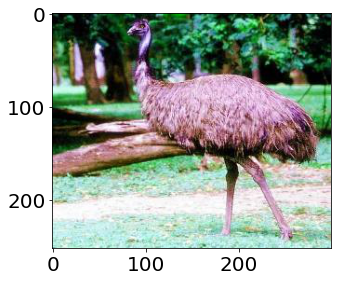

In [34]:
misclass_idx = np.where(y_train!=y_train_hat)

for i in misclass_idx[0]:
    print('The image '+filenames_train[i]+' is misclassified')
    plt.figure(figsize=(5,5))
    I = imageio.imread(filenames_train[i])
    plt.imshow(I)
    plt.show()

## <span style='color:Green'> Your turn: </span>
What does this confusion matrix and accuracy tell you about the performance of the SVM classifier?

### Section 4.3 Training a multi-class classifier
We can use the same `svm.SVC` classifier for a multi-class (more than two classes) classification problem.  Many, but not all classifiers can be applied to binary and multi-class problems.  

## <span style='color:Green'> Your turn: </span>
Use what you learned above to create a three-class classifier using input from the CalTech101 dataset.  The basic two-class code is copied into the cell below for ease of editing.

In [35]:
categories = ('emu', 'flamingo') 

# instantiate empty feature matrices and label vectors
X_train = np.empty((0,97),float)
y_train = list()
X_test = np.empty((0,97),float)
y_test = list()
for category in categories: # loop over categories
    ims = sorted(glob.glob('101_ObjectCategories/'+category+'/*.jpg')) # list of images 
    ans = sorted(glob.glob('Annotations/'+category+'/*.mat')) # corresponding list of annotations
    N_train = np.floor(len(ims)*0.9) # compute number of training samples
    N_test = len(ims) - N_train # compute number of testing samples
    for f,im_filename in enumerate(ims): # loop over all images
        an_filename = ans[f] # grab corresponding annotation filename
        im = np.asarray(imageio.imread(im_filename)) # read in image
        ann = spio.loadmat(an_filename) # load annotation
        r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                                   ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                                   (im.shape[0],im.shape[1])) # compute annotation polygon
        mask = np.zeros((im.shape[0],im.shape[1])) # initialize annotation mask
        mask[r,c] = 1 # define annotation mask
        f_rgb,fnames_rgb = extract_color_features_rgb(im,mask) # extract RGB features
        f_hsv,fnames_hsv = extract_color_features_hsv(im,mask) # extract HSV features
        f_region,fnames_region = extract_region_features(mask.astype(int)) # extract region features
        f_texture,fnames_texture = extract_texture_features(im,mask) # extract texture features
        if f<N_train: # append to training feature matrix and label vector
            X_train = np.vstack((X_train,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_train.append(category)
        else: # append to testing feature matrix and label vector
            X_test = np.vstack((X_test,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_test.append(category)
            
Xn_train,mx,mn = normalize_feature_columns(X_train)
Xn_test = normalize_feature_columns(X_test,mx,mn)

clf = svm.SVC(kernel='linear')
clf.fit(Xn_train,y_train)

y_test_hat = clf.predict(Xn_test)
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat,categories)
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

The confusion matrix is:
[[6 0]
 [0 7]]
The overall accuracy is: 1.0


/Users/jenchang/miniconda/envs/geo_env/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=('emu', 'flamingo') as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Section 4.4 Exploring discriminative capabilities of different features
We can train an SVM using only a subset of the features that we have defined.  This is essentially an exploration of the discriminatory potential of different individual features or sets of features via ablation.  In the code below, we re-compute the feature matrices and label vectors for the `'emu'` versus `'flamingo'` problem.  Since we will be using subsets of features, we extract all features here and will use slicing to send a subset of features to the SVM classifier.

In [36]:
categories = ('emu', 'flamingo') 

# instantiate empty feature matrices and label vectors
X_train = np.empty((0,97),float)
y_train = list()
X_test = np.empty((0,97),float)
y_test = list()
for category in categories: # loop over categories
    ims = sorted(glob.glob('101_ObjectCategories/'+category+'/*.jpg')) # list of images 
    ans = sorted(glob.glob('Annotations/'+category+'/*.mat')) # corresponding list of annotations
    N_train = np.floor(len(ims)*0.9) # compute number of training samples
    N_test = len(ims) - N_train # compute number of testing samples
    for f,im_filename in enumerate(ims): # loop over all images
        an_filename = ans[f] # grab corresponding annotation filename
        im = np.asarray(imageio.imread(im_filename)) # read in image
        ann = spio.loadmat(an_filename) # load annotation
        r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                                   ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                                   (im.shape[0],im.shape[1])) # compute annotation polygon
        mask = np.zeros((im.shape[0],im.shape[1])) # initialize annotation mask
        mask[r,c] = 1 # define annotation mask
        f_rgb,fnames_rgb = extract_color_features_rgb(im,mask) # extract RGB features
        f_hsv,fnames_hsv = extract_color_features_hsv(im,mask) # extract HSV features
        f_region,fnames_region = extract_region_features(mask.astype(int)) # extract region features
        f_texture,fnames_texture = extract_texture_features(im,mask) # extract texture features
        if f<N_train: # append to training feature matrix and label vector
            X_train = np.vstack((X_train,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_train.append(category)
        else: # append to testing feature matrix and label vector
            X_test = np.vstack((X_test,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_test.append(category)
            
Xn_train,mx,mn = normalize_feature_columns(X_train)
Xn_test = normalize_feature_columns(X_test,mx,mn)

In [37]:
clf = svm.SVC(kernel='linear')
clf.fit(Xn_train[:,0:30],y_train)
y_test_hat = clf.predict(Xn_test[:,0:30])
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
print('Color features only:')
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

Color features only:
The confusion matrix is:
[[4 2]
 [2 5]]
The overall accuracy is: 0.6923076923076923


In [38]:
clf = svm.SVC(kernel='linear')
clf.fit(Xn_train[:,30:49],y_train)
y_test_hat = clf.predict(Xn_test[:,30:49])
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
print('Region features only:')
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

Region features only:
The confusion matrix is:
[[6 0]
 [1 6]]
The overall accuracy is: 0.9230769230769231


In [39]:
clf = svm.SVC(kernel='linear')
clf.fit(Xn_train[:,49:],y_train)
y_test_hat = clf.predict(Xn_test[:,49:])
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
print('Texture features only:')
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

Texture features only:
The confusion matrix is:
[[4 2]
 [1 6]]
The overall accuracy is: 0.7692307692307693


## <span style='color:Green'> Your turn: </span>
Choose two or more categories from the CalTech101 dataset that you think might be more or less amenable to discrimination using certain feature subsets.  Using those categories, explore the discriminative capabilities of different feature subsets.  The basic code for using color features only for the `'emu'` versus `'flamingo'` classification problem is copied into the cell below for ease of editing.

In [40]:
categories = ('emu', 'flamingo') 

# instantiate empty feature matrices and label vectors
X_train = np.empty((0,97),float)
y_train = list()
X_test = np.empty((0,97),float)
y_test = list()
for category in categories: # loop over categories
    ims = sorted(glob.glob('101_ObjectCategories/'+category+'/*.jpg')) # list of images 
    ans = sorted(glob.glob('Annotations/'+category+'/*.mat')) # corresponding list of annotations
    N_train = np.floor(len(ims)*0.9) # compute number of training samples
    N_test = len(ims) - N_train # compute number of testing samples
    for f,im_filename in enumerate(ims): # loop over all images
        an_filename = ans[f] # grab corresponding annotation filename
        im = np.asarray(imageio.imread(im_filename)) # read in image
        ann = spio.loadmat(an_filename) # load annotation
        r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                                   ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                                   (im.shape[0],im.shape[1])) # compute annotation polygon
        mask = np.zeros((im.shape[0],im.shape[1])) # initialize annotation mask
        mask[r,c] = 1 # define annotation mask
        f_rgb,fnames_rgb = extract_color_features_rgb(im,mask) # extract RGB features
        f_hsv,fnames_hsv = extract_color_features_hsv(im,mask) # extract HSV features
        f_region,fnames_region = extract_region_features(mask.astype(int)) # extract region features
        f_texture,fnames_texture = extract_texture_features(im,mask) # extract texture features
        if f<N_train: # append to training feature matrix and label vector
            X_train = np.vstack((X_train,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_train.append(category)
        else: # append to testing feature matrix and label vector
            X_test = np.vstack((X_test,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_test.append(category)
            
Xn_train,mx,mn = normalize_feature_columns(X_train)
Xn_test = normalize_feature_columns(X_test,mx,mn)

clf = svm.SVC(kernel='linear')
clf.fit(Xn_train[:,0:30],y_train)
y_test_hat = clf.predict(Xn_test[:,0:30])
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
print('Color features only:')
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

Color features only:
The confusion matrix is:
[[4 2]
 [2 5]]
The overall accuracy is: 0.6923076923076923


### Section 4.5 Other Classifiers
There are many other classifiers available in the `sklearn` package, see https://scikit-learn.org/stable/user_guide.html for documentation.  

## <span style='color:Green'> Your turn: </span>
Explore the capabilities of other classifiers.  If you don't know where to start, some commonly referenced classifiers in the literature are
 - Linear Discriminant Analysis (LDA) available in `sklearn.discriminant_analysis` (Do a `from sklearn import discriminant_analysis` and then use `discriminant_analysis.LinearDiscriminantAnalysis`)
 - k-Nearest Neighbors (KNN) available in `sklearn.neighbors` (Do a `from sklearn import neighbors` and then use `neighbors.KNeighborsClassifier`)
 - Random Forest available in `sklearn.ensemble` (Do a `from sklearn import ensemble` and then use `ensemble.RandomForestClassifier`

In [41]:
from sklearn import discriminant_analysis
categories = ('emu', 'flamingo') 

# instantiate empty feature matrices and label vectors
X_train = np.empty((0,97),float)
y_train = list()
X_test = np.empty((0,97),float)
y_test = list()
for category in categories: # loop over categories
    ims = sorted(glob.glob('101_ObjectCategories/'+category+'/*.jpg')) # list of images 
    ans = sorted(glob.glob('Annotations/'+category+'/*.mat')) # corresponding list of annotations
    N_train = np.floor(len(ims)*0.9) # compute number of training samples
    N_test = len(ims) - N_train # compute number of testing samples
    for f,im_filename in enumerate(ims): # loop over all images
        an_filename = ans[f] # grab corresponding annotation filename
        im = np.asarray(imageio.imread(im_filename)) # read in image
        ann = spio.loadmat(an_filename) # load annotation
        r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                                   ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                                   (im.shape[0],im.shape[1])) # compute annotation polygon
        mask = np.zeros((im.shape[0],im.shape[1])) # initialize annotation mask
        mask[r,c] = 1 # define annotation mask
        f_rgb,fnames_rgb = extract_color_features_rgb(im,mask) # extract RGB features
        f_hsv,fnames_hsv = extract_color_features_hsv(im,mask) # extract HSV features
        f_region,fnames_region = extract_region_features(mask.astype(int)) # extract region features
        f_texture,fnames_texture = extract_texture_features(im,mask) # extract texture features
        if f<N_train: # append to training feature matrix and label vector
            X_train = np.vstack((X_train,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_train.append(category)
        else: # append to testing feature matrix and label vector
            X_test = np.vstack((X_test,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_test.append(category)
            
Xn_train,mx,mn = normalize_feature_columns(X_train)
Xn_test = normalize_feature_columns(X_test,mx,mn)

clf = discriminant_analysis.LinearDiscriminantAnalysis()
clf.fit(Xn_train,y_train)
y_test_hat = clf.predict(Xn_test)
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

The confusion matrix is:
[[5 1]
 [3 4]]
The overall accuracy is: 0.6923076923076923


In [42]:
from sklearn import neighbors
categories = ('emu', 'flamingo') 

# instantiate empty feature matrices and label vectors
X_train = np.empty((0,97),float)
y_train = list()
X_test = np.empty((0,97),float)
y_test = list()
for category in categories: # loop over categories
    ims = sorted(glob.glob('101_ObjectCategories/'+category+'/*.jpg')) # list of images 
    ans = sorted(glob.glob('Annotations/'+category+'/*.mat')) # corresponding list of annotations
    N_train = np.floor(len(ims)*0.9) # compute number of training samples
    N_test = len(ims) - N_train # compute number of testing samples
    for f,im_filename in enumerate(ims): # loop over all images
        an_filename = ans[f] # grab corresponding annotation filename
        im = np.asarray(imageio.imread(im_filename)) # read in image
        ann = spio.loadmat(an_filename) # load annotation
        r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                                   ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                                   (im.shape[0],im.shape[1])) # compute annotation polygon
        mask = np.zeros((im.shape[0],im.shape[1])) # initialize annotation mask
        mask[r,c] = 1 # define annotation mask
        f_rgb,fnames_rgb = extract_color_features_rgb(im,mask) # extract RGB features
        f_hsv,fnames_hsv = extract_color_features_hsv(im,mask) # extract HSV features
        f_region,fnames_region = extract_region_features(mask.astype(int)) # extract region features
        f_texture,fnames_texture = extract_texture_features(im,mask) # extract texture features
        if f<N_train: # append to training feature matrix and label vector
            X_train = np.vstack((X_train,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_train.append(category)
        else: # append to testing feature matrix and label vector
            X_test = np.vstack((X_test,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_test.append(category)
            
Xn_train,mx,mn = normalize_feature_columns(X_train)
Xn_test = normalize_feature_columns(X_test,mx,mn)

clf = neighbors.KNeighborsClassifier()
clf.fit(Xn_train,y_train)
y_test_hat = clf.predict(Xn_test)
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))

The confusion matrix is:
[[6 0]
 [1 6]]
The overall accuracy is: 0.9230769230769231


In [43]:
from sklearn import ensemble
categories = ('emu', 'flamingo') 

# instantiate empty feature matrices and label vectors
X_train = np.empty((0,97),float)
y_train = list()
X_test = np.empty((0,97),float)
y_test = list()
for category in categories: # loop over categories
    ims = sorted(glob.glob('101_ObjectCategories/'+category+'/*.jpg')) # list of images 
    ans = sorted(glob.glob('Annotations/'+category+'/*.mat')) # corresponding list of annotations
    N_train = np.floor(len(ims)*0.9) # compute number of training samples
    N_test = len(ims) - N_train # compute number of testing samples
    for f,im_filename in enumerate(ims): # loop over all images
        an_filename = ans[f] # grab corresponding annotation filename
        im = np.asarray(imageio.imread(im_filename)) # read in image
        ann = spio.loadmat(an_filename) # load annotation
        r,c = skimage.draw.polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,\
                                   ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,\
                                   (im.shape[0],im.shape[1])) # compute annotation polygon
        mask = np.zeros((im.shape[0],im.shape[1])) # initialize annotation mask
        mask[r,c] = 1 # define annotation mask
        f_rgb,fnames_rgb = extract_color_features_rgb(im,mask) # extract RGB features
        f_hsv,fnames_hsv = extract_color_features_hsv(im,mask) # extract HSV features
        f_region,fnames_region = extract_region_features(mask.astype(int)) # extract region features
        f_texture,fnames_texture = extract_texture_features(im,mask) # extract texture features
        if f<N_train: # append to training feature matrix and label vector
            X_train = np.vstack((X_train,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_train.append(category)
        else: # append to testing feature matrix and label vector
            X_test = np.vstack((X_test,np.concatenate((f_rgb,f_hsv,f_region,f_texture))))
            y_test.append(category)
            
Xn_train,mx,mn = normalize_feature_columns(X_train)
Xn_test = normalize_feature_columns(X_test,mx,mn)

clf = ensemble.RandomForestClassifier()
clf.fit(Xn_train,y_train)
y_test_hat = clf.predict(Xn_test)
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
print('The confusion matrix is:')
print(C)
acc = np.diag(C).sum().astype(float)/C.sum()
print('The overall accuracy is: '+ str(acc))


The confusion matrix is:
[[6 0]
 [0 7]]
The overall accuracy is: 1.0
